# Profile-based retrieval

In [1]:
!pip install nltk
import pandas as pd
import csv
import numpy as np
import nltk
import re
import string as st
import random

import matplotlib.pyplot as plt

from nltk.tokenize import RegexpTokenizer
from nltk import PorterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
     ---- ----------------------------------- 0.2/1.5 MB 4.6 MB/s eta 0:00:01
     --------------- ------------------------ 0.6/1.5 MB 9.4 MB/s eta 0:00:01
     ---------------------------- ----------- 1.1/1.5 MB 9.7 MB/s eta 0:00:01
     ---------------------------------------  1.5/1.5 MB 10.7 MB/s eta 0:00:01
     ---------------------------------------- 1.5/1.5 MB 9.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/96.6 kB ? eta -:--:--
     ---------------------------------------- 96.6/96.6 kB 5.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/267.9 kB ? eta -:--:--
     ------------------------------------- 267.9/267.9 kB 17.2 MB/s eta 0:00:00


### Data Loading

In [2]:
train = pd.read_csv(r'BBC news train.csv')
train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


## 1. Data preparation

* Remove punctuation
* Convert text to tokens
* Remove tokens of length less than or equal to 3
* Remove stopwords using NLTK corpus stopwords list to match
* Apply stemming
* Apply lemmatization
* Convert words to feature vectors

In [8]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\javie\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\javie\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\javie\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\javie\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers\averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\javie\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping grammars\basque_grammars.zip.
[nltk_data]   

True

#### 1.1-Removing punctuations form the text

In [6]:
def remove_punct(text):
    return ("".join([ch for ch in text if ch not in st.punctuation]))

In [7]:
train['removed_punc'] = train['Text'].apply(lambda x: remove_punct(x))
train.head()

,ArticleId,Text,Category,removed_punc
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...


#### 1.2-Convert text to tokens

Convert text to lower case tokens. Here, split() is applied on white-spaces. But, it could be applied
    on special characters, tabs or any other string based on which text is to be seperated into tokens.

In [7]:
def tokenize(text):
    text = re.split('\s+' ,text)
    return [x.lower() for x in text]

In [8]:
train['tokens'] = train['removed_punc'].apply(lambda msg : tokenize(msg))
train.head()

,ArticleId,Text,Category,removed_punc,tokens
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,..."
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize..."
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo..."


#### 1.3- Remove tokens of length less than or equal to 3

In [9]:
def remove_small_words(text):
    return [x for x in text if len(x) > 3 ]

In [10]:
train['larger_tokens'] = train['tokens'].apply(lambda x : remove_small_words(x))
train.head()

,ArticleId,Text,Category,removed_punc,tokens,larger_tokens
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,..."
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize...","[poll, indicates, economic, gloom, citizens, m..."
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo...","[enron, bosses, 168m, payout, eighteen, former..."


#### 1.4-Remove stopwords using NLTK corpus stopwords list to match

Remove stopwords. Here, NLTK corpus list is used for a match. However, a customized user-defined list could be created and used to limit the matches in input text. 

In [11]:
def remove_stopwords(text):
    return [word for word in text if word not in nltk.corpus.stopwords.words('english')]

In [12]:
train['clean_tokens'] = train['larger_tokens'].apply(lambda x : remove_stopwords(x))
train.head()

,ArticleId,Text,Category,removed_punc,tokens,larger_tokens,clean_tokens
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,..."
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizens, m..."
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo...","[enron, bosses, 168m, payout, eighteen, former...","[enron, bosses, 168m, payout, eighteen, former..."


#### 1.5-Apply stemming

Apply stemming to get root words 

In [13]:
def stemming(text):
    ps = PorterStemmer()
    return [ps.stem(word) for word in text]

In [14]:
train['stem_words'] = train['clean_tokens'].apply(lambda wrd: stemming(wrd))
train.head()

,ArticleId,Text,Category,removed_punc,tokens,larger_tokens,clean_tokens,stem_words
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launch, defenc, lawyer, def..."
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, busi, confid, slide, german, busi, co..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizens, m...","[poll, indic, econom, gloom, citizen, major, n..."
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyl, govern, mobil, choic, faster, bette..."
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo...","[enron, bosses, 168m, payout, eighteen, former...","[enron, bosses, 168m, payout, eighteen, former...","[enron, boss, 168m, payout, eighteen, former, ..."


#### 1.6-Apply lemmatization

Lemmatization converts word to it's dictionary base form. This process takes language grammar and vocabulary into consideration while conversion. Hence, it is different from Stemming in that it does not merely truncate the suffixes to get the root word.

In [15]:
def lemmatize(text):
    word_net = WordNetLemmatizer()
    return [word_net.lemmatize(word) for word in text]

In [16]:
train['lemma_words'] = train['clean_tokens'].apply(lambda x : lemmatize(x))
train.head()

,ArticleId,Text,Category,removed_punc,tokens,larger_tokens,clean_tokens,stem_words,lemma_words
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launch, defenc, lawyer, def...","[worldcom, exboss, launch, defence, lawyer, de..."
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, busi, confid, slide, german, busi, co...","[german, business, confidence, slide, german, ..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizens, m...","[poll, indic, econom, gloom, citizen, major, n...","[poll, indicates, economic, gloom, citizen, ma..."
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyl, govern, mobil, choic, faster, bette...","[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo...","[enron, bosses, 168m, payout, eighteen, former...","[enron, bosses, 168m, payout, eighteen, former...","[enron, boss, 168m, payout, eighteen, former, ...","[enron, boss, 168m, payout, eighteen, former, ..."


Annotate each word with its part-of-speech tag

In [17]:
def get_pos_tag(tokenized_sentence):
    return nltk.pos_tag(tokenized_sentence)

In [18]:
train['pos_tag'] = train['tokens'].apply(lambda x : get_pos_tag(x))
train.head()

,ArticleId,Text,Category,removed_punc,tokens,larger_tokens,clean_tokens,stem_words,lemma_words,pos_tag
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launch, defenc, lawyer, def...","[worldcom, exboss, launch, defence, lawyer, de...","[(worldcom, NN), (exboss, NN), (launches, VBZ)..."
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, busi, confid, slide, german, busi, co...","[german, business, confidence, slide, german, ...","[(german, JJ), (business, NN), (confidence, NN..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizens, m...","[poll, indic, econom, gloom, citizen, major, n...","[poll, indicates, economic, gloom, citizen, ma...","[(bbc, NN), (poll, NN), (indicates, VBZ), (eco..."
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyl, govern, mobil, choic, faster, bette...","[lifestyle, governs, mobile, choice, faster, b...","[(lifestyle, JJ), (governs, NNS), (mobile, JJ)..."
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo...","[enron, bosses, 168m, payout, eighteen, former...","[enron, bosses, 168m, payout, eighteen, former...","[enron, boss, 168m, payout, eighteen, former, ...","[enron, boss, 168m, payout, eighteen, former, ...","[(enron, NN), (bosses, NNS), (in, IN), (168m, ..."


#### 1.7-Convert words to feature vectors

Create sentences to get clean text as input for vectors

In [19]:
def return_sentences(tokens):
    return " ".join([word for word in tokens])

In [20]:
train['clean_text'] = train['lemma_words'].apply(lambda x : return_sentences(x))
train.head()

,ArticleId,Text,Category,removed_punc,tokens,larger_tokens,clean_tokens,stem_words,lemma_words,pos_tag,clean_text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launch, defenc, lawyer, def...","[worldcom, exboss, launch, defence, lawyer, de...","[(worldcom, NN), (exboss, NN), (launches, VBZ)...",worldcom exboss launch defence lawyer defendin...
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, busi, confid, slide, german, busi, co...","[german, business, confidence, slide, german, ...","[(german, JJ), (business, NN), (confidence, NN...",german business confidence slide german busine...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizens, m...","[poll, indic, econom, gloom, citizen, major, n...","[poll, indicates, economic, gloom, citizen, ma...","[(bbc, NN), (poll, NN), (indicates, VBZ), (eco...",poll indicates economic gloom citizen majority...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyl, govern, mobil, choic, faster, bette...","[lifestyle, governs, mobile, choice, faster, b...","[(lifestyle, JJ), (governs, NNS), (mobile, JJ)...",lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo...","[enron, bosses, 168m, payout, eighteen, former...","[enron, bosses, 168m, payout, eighteen, former...","[enron, boss, 168m, payout, eighteen, former, ...","[enron, boss, 168m, payout, eighteen, former, ...","[(enron, NN), (bosses, NNS), (in, IN), (168m, ...",enron boss 168m payout eighteen former enron d...


Columns of the dataframe we are more interested in.

In [21]:
train[['Category','clean_text']]

,Category,clean_text
0,business,worldcom exboss launch defence lawyer defendin...
1,business,german business confidence slide german busine...
2,business,poll indicates economic gloom citizen majority...
3,tech,lifestyle governs mobile choice faster better ...
4,business,enron boss 168m payout eighteen former enron d...
...,...,...
1485,entertainment,double eviction brother model caprice holby ci...
1486,entertainment,double revamp chart show joel taking radio fla...
1487,business,weak dollar hit reuters revenue medium group r...
1488,tech,apple ipod family expands market apple expande...


## 2. PROFILE-BASED RETRIEVAL IMPLEMENTATION

### TF-IDF : Term Frequency - Inverse Document Frequency

#### 2.1 - Documents

Each document is going to be define as a vector depending on the importance of a word in a document.

In [22]:
vectorizer = TfidfVectorizer(norm='l2', use_idf=False)
tfidf_vect = vectorizer.fit_transform(train['clean_text']).toarray()
tfidf_vect.shape

(1490, 23294)

In [23]:
#tf-idf vectors matrix
tokens = []
for i, feature in enumerate(vectorizer.get_feature_names_out()):
    tokens.append(feature)
tfidf_matrix = pd.DataFrame(tfidf_vect, columns = tokens)
tfidf_matrix.iloc[:,7000:]

,dock,docked,docking,docklands,docomo,doctor,doctored,doctoring,doctorow,docudrama,...,zombie,zone,zonealarm,zoom,zooropa,zorro,zuluaga,zurich,zutons,zvonareva
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
#vectorize documents
document_vectors = vectorizer.fit_transform(train["clean_text"])

#### 2.2- Users

Once we have every document as a vector with the term frecuency, we are going to create a vector to define 5 different users interested in the categories presented in the data. These categories are: business, tech, politics, sport and entertainment.

In [25]:
#business
user1 =  ["company", "market", "entrepreneurship","bank", "conuntry", "analyst", "economic", "startups", "financial", "marketing", "leadership", 
          "innovation", "investment", "sales", "business", "product development", "capital", "branding", "consumer", "supply chain management", 
          "market research", "entrepreneurial mindset", "competitive advantage","risk management", "growth", "startup culture", "dollar",
          "crowdfunding", "digital marketing", "social media", "customer experience", "entrepreneurial ecosystem", "networking", "e-commerce", 
          "online marketing", "data analytics", "management consulting", "strategic planning", "business ethics","group", "sustainability", 
          "corporate responsibility","globalization", "international","business", "trade", "emerging markets", "industry analysis", "economy", 
          "financial", "invest", "career", "development"]

#tech
user2 =  ["technology", "mobile", "technology","internet","website" ,"phone", "device", "game","gadget", "machine", "learning", "data", "science", "cloud", "computer", "cybersecurity", 
         "blockchain", "information", "virtual", "virus", "augmented", "reality", "robotics", "automation", "software", "development", "web", "development", 
         "mobile", "development", "system", "microsoft", "product", "design", "management", "agile", "methodology", "network", "digital", "transformation", "innovation", "online", 
         "venture","broadband", "capital", "media", "events", "policy", "ethics", "privacy", "patents", "copyright", "surveillance", "consumer", "printing", "drones", "nanotechnology", 
         "player"]

#politics
user3 = ["politics", "government", "election", "voting", "democracy", "campaign", "power", "public","people","minister","party", "leader", "tory", "international", "plan", "diplomacy", 
         "foreign policy", "war", "peace", "human", "right", "labour", "immigration", "trade", "economics", "change","taxes", "budgets", "council", "inequality", "vote", "activism", 
         "protest", "lobbying", "media", "propaganda", "chancellor", "prime", "political ideologies", "political parties", "political systems", "authoritarianism", "general", "liberalism", 
         "conservatism", "fascism", "communism", "conservative","anarchism", "right","federalism", "parliamentary system", "presidential system", "judicial system", "constitution", "sercretry", "country"]

#sports
user4 = ["basketball", "game", "match","football", "baseball", "hockey", "soccer", "rugby","swimming", "tennis", "golf", "athlete", "player", "training", "fitness", "nutrition", 
         "sports psychology", "performance", "strength", "endurance", "final","health", "wellness", "coach", "team", "competition", "season","time","champion", "victory", "athleticism", 
         "motivation", "dedication", "passion", "sportsmanship", "fan", "stadium", "tickets", "play", "fantasy sports", "sports media", "sports journalism", "injury", "sports science", 
         "goal", "sports technology","sports equipment", "sports apparel", "open", "sports leagues", "sports events", "sports personalities", "sports icons", "sports culture"]

#entertainment
user5 = ["entertainment", "film","movie", "television", "music","award","show", "books","oscar", "art", "performing", "arts", "theater", "comedy", "celebrities", "pop", "culture", "fashion", 
         "gaming", "streaming", "social", "media","record","producer", "band","song","single", "director", "Instagram", "influencers", "fan", "culture", "fandom", "play","role",
         "nomination","prize", "convention", "festival", "satar", "actor", "red", "carpet", "critics", "reviews", "box", "office", "ratings", "soundtracks", "visual", "effects", 
         "animation", "cartoons", "manga", "anime", "album", "horror", "fantasy","romance", "actress", "singer"]


In [26]:
topics_interest = ['business', 'tech', 'politics', 'sport', 'entertainment', 'sport and politics', 'business and tech', 
          'sport and entertainment', 'business and politics', 'politics and entertainment']
users_keywords = [user1, user2, user3, user4, user5]

These arrays of keywords have been transformed into vectors. Have also been addeed 5 more users interested in more than one topic. To obtain these vectors the average of the two categories has been made. 

In [27]:
users_vectors =[]
for i in users_keywords:
    users_vectors.append(vectorizer.transform([" ".join(i)]))

#we add the vectors with the combinations of two topics
#user 6 - sport and politics
users_vectors.append((users_vectors[2]+users_vectors[3])/2)
#user 7 - business and tech 
users_vectors.append((users_vectors[0]+users_vectors[1])/2)
#user 8 - sport and entertainment
users_vectors.append((users_vectors[3]+users_vectors[4])/2)
#user 9 - business and politics
users_vectors.append((users_vectors[0]+users_vectors[2])/2)
#user 10 politics and entertainment
users_vectors.append((users_vectors[2]+users_vectors[4])/2)

These are the users and its interests:
* user 1: business
* user 2: tech
* user 3: politics
* user 4: sport
* user 5: entertainment
* user 6: sport and politics
* user 7: business and tech 
* user 8: sport and entertainment
* user 9: business and politics
* user 10: politics and entertainment

### COSINE SIMILARITY

#### FIRT SOLUTION

Given the vector of a user define by its interests, the cosine similarity has been calculated with every document.

In [28]:
#vectores que caractereizan a los usuarios
users_vectors # 10 users

#vetores que caracterizan los docuemntos 
document_vectors # 1490 documents

<1490x23294 sparse matrix of type '<class 'numpy.float64'>'
	with 204925 stored elements in Compressed Sparse Row format>

DataFrame: we will have in each row the value of the cosine similarity with the vector of each user (columns). In each iteration we will add these similarities per user.

In [29]:
 #similiarities df
sim_df = pd.DataFrame(columns=['ArticleId', 'Text','user1', 'user2', 'user3', 'user4', 'user5','user6', 'user7','user8','user9','user10','Category'])
sim_df['ArticleId'] = train['ArticleId']
#sim_df['Text'] = train['Text'][:100]#opocion de cambiarlo a clean_text
sim_df['Text'] = train['Text']
sim_df['Category'] = train['Category']

In [30]:
#save in a df the cosine similarity of each document and user
df_index = 2
for i in range(len(users_vectors)):
    similarities_list = []

    for j in range(len(list(document_vectors))):
        similarity = cosine_similarity(users_vectors[i], document_vectors[j])
        similarities_list.append(similarity[0][0])
    
    sim_df[sim_df.columns[df_index]] = similarities_list
    df_index+=1


In [31]:
sim_df.head()

,ArticleId,Text,user1,user2,user3,user4,user5,user6,user7,user8,user9,user10,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,0.042189,0.000000,0.000000,0.000000,0.007181,0.000000,0.027000,0.004822,0.029442,0.005078,business
1,154,german business confidence slides german busin...,0.147222,0.014465,0.020998,0.000000,0.008019,0.014848,0.103476,0.005385,0.117392,0.020518,business
2,1101,bbc poll indicates economic gloom citizens in ...,0.076499,0.018791,0.122748,0.010880,0.005208,0.094489,0.060983,0.010804,0.139044,0.090478,business
3,1976,lifestyle governs mobile choice faster bett...,0.054556,0.197075,0.041958,0.018257,0.008740,0.042578,0.161037,0.018129,0.067352,0.035848,tech
4,917,enron bosses in $168m payout eighteen former e...,0.083684,0.000000,0.006631,0.000000,0.045580,0.004689,0.053556,0.030608,0.063026,0.036919,business


In [32]:
sort_1 = sim_df.sort_values('user1', ascending=False)
sort_1[:10]['Text']

1257    booming markets shed few tears the market  for...
1422    uk firms  embracing e-commerce  uk firms are e...
184     businesses fail to plan for hiv companies fail...
142     irish markets reach all-time high irish shares...
706     italy to get economic action plan italian prim...
95      durex maker ssl awaits firm bid uk condom make...
996     battered dollar hits another low the dollar ha...
1368    india widens access to telecoms india has rais...
834     consumers drive french economy france s econom...
1366    business fears over sluggish eu economy as eur...
Name: Text, dtype: object

#### SECOND SOLUTION

Given a random document, the cosine similarity between its vector and every user’s vector is calculated.

In [33]:
random_index = random.randint(0, len(train["Text"])-1) #random document from the dataset. 
incoming_doc_vector = document_vectors[random_index]
list_sim = []
perfiles = []
topics = []

for j in range(len(users_vectors)-1):
    similarities = cosine_similarity(incoming_doc_vector, users_vectors[j]) #cosine distance between the document and the users
    perfiles.append(j+1)
    topics.append(topics_interest[j])
    list_sim.append(similarities[0][0])

#return the document, the users are going to receive that document and the main topic related to the document. 

ranking = pd.DataFrame()
ranking["Users"] = perfiles
ranking['Topics'] = topics
ranking["Score"] = list_sim
ranking = ranking.sort_values('Score', ascending=False)

max_index = ranking['Score'].idxmax() #df index of the maximun score value in the ranking
max_row = ranking.loc[max_index]# row with the maximun score

print("For document",train['ArticleId'][random_index], ":", train["Text"][random_index])
print(train['Category'][random_index], '-- ', max_row['Topics'])
print('USERS RANKING')
print(ranking)
for index, row in ranking.iterrows():
    if row[2] > 0.015:
        print('user interested: ', row[0])


For document 572 : tories urge  change at the top  tory delegates are gathering for what is expected to be their last conference before the general election  declaring britain needs  a change at the top .  the party goes into its spring forum trying to highlight what it sees as a clear choice between it and labour. tory co-chairman liam fox has opened proceedings with a speech criticising tony blair s record in government. labour s rule has been characterised by  lost trust and failure to deliver   he told the brighton conference. he also attacked the government s  failure  to control immigration and asylum and criticised its record on the nhs  telling delegates labour cannot be trusted on education or crime. a tory government would sort out the  shambles  of immigration  put patients before statistics and bring discipline to schools  he said. dr fox also underlined tory promises to cut tax by £4bn.  bbc political correspondent shaun ley says opinion polls suggest the tories still lag 

Saving the similiratites the users that will receive each document using a threshold in the cosine similarity.

In [48]:
correct = 0
cont = 0
users_interested_dict = {}
for i in range(1490):
    random_index= i
    incoming_doc_vector = document_vectors[random_index]
    list_sim = []
    perfiles = []
    topics = []
    
    for j in range(len(users_vectors)-1):
        similarities = cosine_similarity(incoming_doc_vector, users_vectors[j]) #cosine distance between the document and the users
        perfiles.append(j+1)
        topics.append(topics_interest[j])
        list_sim.append(similarities[0][0])

    #ranking of the users
    ranking = pd.DataFrame()
    ranking["Users"] = perfiles
    ranking['Topics'] = topics
    ranking["Score"] = list_sim
    
    users = [] #useres interested in the document
    threshold =  ranking['Score'].mean()
    for index, row in ranking.iterrows():
        if row[2] > threshold:
            users.append(row[1])
    users_interested_dict.update({i:users}) #dictionary with the documents id and the  predicted users interested.

Regarding the ranking we will establish a threshold to retreive the document only to those users that are interested in the topic. With this threshold (the all cosine similarities mean) two documents do not have users interested.

Documents that due to the threshold chosen has not users interested

In [49]:
for key in users_interested_dict:
    if not users_interested_dict[key]:
        print(f"The document '{key}' does not have users interested.")

The document '126' does not have users interested.
The document '363' does not have users interested.


In [50]:
del users_interested_dict[126]
del users_interested_dict[363]

## 3- INFORMATION RETRIEVAL EVALUATION

### 3.1- FIRST SOLUTION

In [37]:
def evaluate(ex,Q,R):
    nq=len(Q)
    nd=len(Q[0])
    R_=np.array(R)
    R_=.5*(R_+1)
    Prec_tot=[]
    Rec_tot=[]    
    def compute_PR(print_screen=True):
        Prec_tot=[]
        Rec_tot=[]        
        if print_screen:
            print('Precision and Recall at k for k=1,...,%d'%nd)      
        for q in range(nq):
            q1=q+1
            r=R_[q,:]
            if print_screen:
                print('\tQuery %d'%q1)
            Prec_q=[]
            Rec_q=[]
            for k in range(nd):
                k1=k+1
                Prec=np.sum(r[:k1])/k1
                Rec=np.sum(r[:k1])/np.sum(r)                
                if print_screen:                    
                    print('\t\tP(%d)=%d/%d=%.2f,\tR(%d)=%d/%d=%.2f'\
                     %(k1, np.sum(r[:k1]), k1, Prec, k1, np.sum(r[:k1]),np.sum(r),Rec))
                Prec_q.append(Prec)
                Rec_q.append(Rec)
            Prec_tot.append(Prec_q)
            Rec_tot.append(Rec_q)
        Prec_tot=np.array(Prec_tot)
        Rec_tot=np.array(Rec_tot)
        return Prec_tot, Rec_tot
    def compute_TPFP(TP_rate=None):
        TP_tot=[]        
        FP_tot=[]        
        print('TP_rate and FP_rate at k for k=1,...,%d'%nd)      
        for q in range(nq):
            q1=q+1
            r=R_[q,:]
            nr=1-r
            print('\tQuery %d'%q1)
            TP_q=[]
            FP_q=[]
            for k in range(nd):
                k1=k+1
                TP=np.sum(r[:k1])/np.sum(r)                
                FP=np.sum(nr[:k1])/np.sum(nr)
                
                print('\t\tTP_rate(%d)=R(%d)=%d/%d=%.2f\t FP_rate(%d)=%d/%d=%.2f\t'\
                     %(k1, k1, np.sum(r[:k1]),np.sum(r),TP, k1,np.sum(nr[:k1]),np.sum(nr),FP))
                TP_q.append(TP)
                FP_q.append(FP)
            TP_tot.append(TP_q)
            FP_tot.append(FP_q)
        TP_tot=np.array(TP_tot)
        FP_tot=np.array(FP_tot)
        return TP_tot, FP_tot        
    if ex=='prec_rec' or ex=='all':        
        Prec_tot, Rec_tot=compute_PR()
        print('\n Draw the Precision-Recall curve for each query')  
        for q in range(nq):
            q1=q+1
            print('\tQuery %d'%q1)            
            plt.figure()
            Rec_q=Rec_tot[q,:]
            Prec_q=Prec_tot[q,:]
            plt.scatter(np.array(Rec_q), np.array(Prec_q))
            plt.plot(np.array(Rec_q), np.array(Prec_q),label='Precision-Recall curve')            
            plt.xlim([-0.05,1.05]); plt.ylim([-0.05,1.05])
            plt.xlabel('Recall'); plt.ylabel('Precision')
            R_int=np.hstack([0,Rec_q,1])
            P_int=np.zeros(R_int.size)
            for i_r in range(R_int.size-1):
                r=R_int[i_r]
                if i_r!=0 and R_int[i_r+1]==r:
                    P_int[i_r]=np.max(Prec_q[i_r-1:])    
                else:
                    P_int[i_r]=np.max(Prec_q[i_r:])            
            plt.plot(R_int,P_int,color='r',label='Interpolated PR curve')
            plt.legend(loc='lower left')
            plt.show()
    if ex=='r-prec' or ex=='all':        
        if Prec_tot==[]:
            Prec_tot, Rec_tot=compute_PR()
        print('\n Determine R-precision for each query') 
        for q in range(nq):            
            Rec_q=Rec_tot[q,:]
            Prec_q=Prec_tot[q,:]
            r=int(np.sum(R_[q]))
            q1=q+1
            print('\tQuery %d'%q1)
            print('\t\tNumber of relevant documents: %d --> P(%d)=%.2f'%(r,r,Prec_q[r-1]))
    if ex=='map' or ex=='all':        
        if Prec_tot==[]:
            Prec_tot, Rec_tot=compute_PR()
        print('\n Calculate the Mean Average Precision')
        APs=[]
        for q in range(nq):            
            Prec_q=Prec_tot[q,:]            
            r=int(np.sum(R_[q]))
            q1=q+1
            print('\tQuery %d'%q1)
            str_formula='1/%d '%r
            rs=np.where(R_[q]==1)[0]+1
            str_formula+='{' + ' + '.join(['P(%d)'%rs_ for rs_ in rs]) + '}'
            AP=np.mean(Prec_q[np.where(R_[q]==1)])            
            print('\t\tAP=%s=%.2f'%(str_formula, AP))
            APs.append(AP)
        APstring='1/%d {'%nq
        APstring+= ' + '.join(['AP_%d'%(q+1) for q in range(nq)]) 
        APstring+='}=1/%d {'%nq
        APstring+= ' + '.join(['%.2f'%(AP) for AP in APs]) 
        APstring+='}'        
        print('\tMAP=%s=%.2f'%(APstring, np.mean(np.array(APs))))
    if ex=='roc' or ex=='all' or ex=='auc':
        TP_tot, FP_tot=compute_TPFP()    
        print('\n Draw the ROC curve for each query')  
        for q in range(nq):
            q1=q+1
            print('\tQuery %d'%q1)            
            plt.figure()
            TP_q=TP_tot[q,:]
            FP_q=FP_tot[q,:]
            plt.scatter(np.array(FP_q), np.array(TP_q))
            TP_q_=np.hstack([0,TP_q,1])
            FP_q_=np.hstack([0,FP_q,1])
            plt.plot(np.array(FP_q_), np.array(TP_q_),label='ROC curve')            
            plt.xlim([-0.05,1.05]); plt.ylim([-0.05,1.05])
            plt.xlabel('FP rate'); plt.ylabel('TP rate')
            plt.show()
            if ex=='auc' or ex=='all':
                AUC=[]
                for i_x in range(TP_q_.size-1):
                    delta_x=FP_q_[i_x+1]-FP_q_[i_x]
                    base=TP_q_[i_x+1]+TP_q_[i_x]
                    AUC.append(base*delta_x/2)
                AUC=np.array(AUC)
                AUC=AUC[AUC>0]
                string_AUC=' + '.join(['%.2f'%auc for auc in AUC])
                if string_AUC!='':
                    string_AUC+=' = '    
                print('\tAUC = %s %.2f\n\n'%(string_AUC, np.sum(AUC)))            
    if ex=='clear':
        return

In [38]:
topics_interest = ['business', 'tech', 'politics', 'sport', 'entertainment', 'sport|politics', 'business|tech', 
          'sport|entertainment', 'business|politics', 'politics|entertainment']
users_list = ['user1', 'user2', 'user3', 'user4', 'user5', 'user6', 'user7', 'user8', 'user9', 'user10']

In [39]:
q=[]
r=[]

for i in range(len(users_list)):
    qi = sim_df.sort_values(users_list[i], ascending=False)
    ri = qi['Category'].str.contains(topics_interest[i]) 

    q.append(qi)
    r.append(ri)


Precision and Recall at k for k=1,...,1490
	Query 1
		P(1)=1/1=1.00,	R(1)=1/913=0.00
		P(2)=1/2=0.75,	R(2)=1/913=0.00
		P(3)=2/3=0.83,	R(3)=2/913=0.00
		P(4)=3/4=0.88,	R(4)=3/913=0.00
		P(5)=4/5=0.90,	R(5)=4/913=0.00
		P(6)=5/6=0.92,	R(6)=5/913=0.01
		P(7)=6/7=0.93,	R(7)=6/913=0.01
		P(8)=7/8=0.94,	R(8)=7/913=0.01
		P(9)=8/9=0.94,	R(9)=8/913=0.01
		P(10)=9/10=0.95,	R(10)=9/913=0.01
		P(11)=10/11=0.95,	R(11)=10/913=0.01
		P(12)=11/12=0.96,	R(12)=11/913=0.01
		P(13)=12/13=0.96,	R(13)=12/913=0.01
		P(14)=13/14=0.96,	R(14)=13/913=0.01
		P(15)=14/15=0.97,	R(15)=14/913=0.02
		P(16)=15/16=0.97,	R(16)=15/913=0.02
		P(17)=16/17=0.97,	R(17)=16/913=0.02
		P(18)=17/18=0.97,	R(18)=17/913=0.02
		P(19)=18/19=0.97,	R(19)=18/913=0.02
		P(20)=19/20=0.97,	R(20)=19/913=0.02
		P(21)=20/21=0.98,	R(21)=20/913=0.02
		P(22)=21/22=0.98,	R(22)=21/913=0.02
		P(23)=22/23=0.98,	R(23)=22/913=0.02
		P(24)=23/24=0.98,	R(24)=23/913=0.03
		P(25)=24/25=0.98,	R(25)=24/913=0.03
		P(26)=25/26=0.98,	R(26)=25/913=0.03
		P(27)

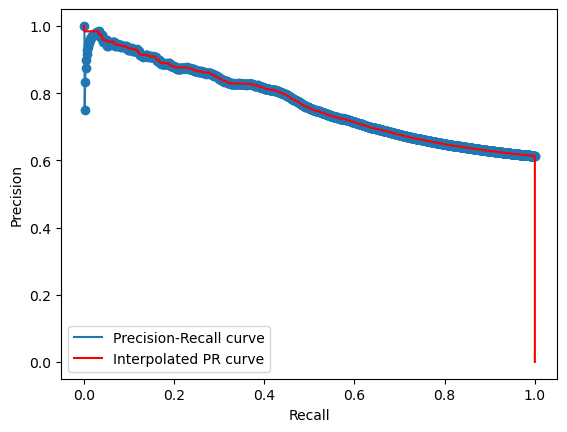

	Query 2


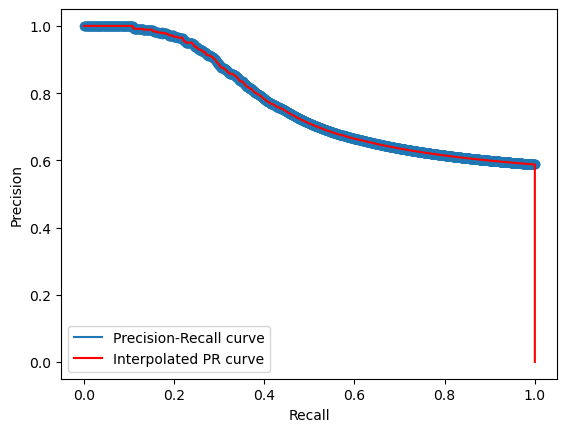

	Query 3


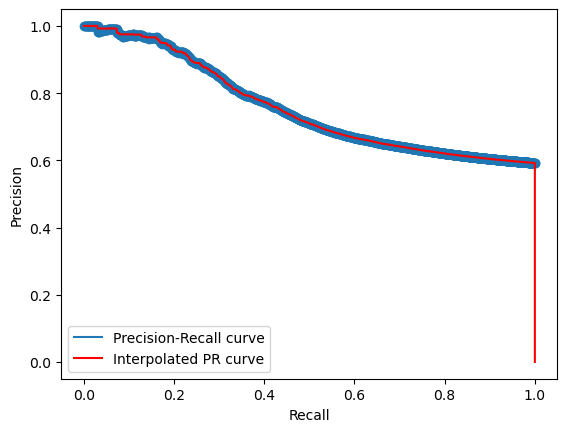

	Query 4


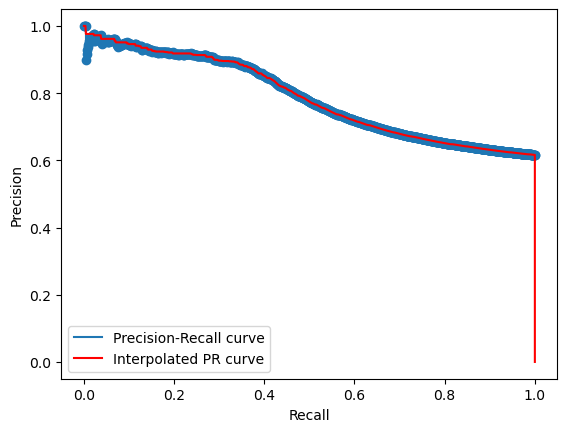

	Query 5


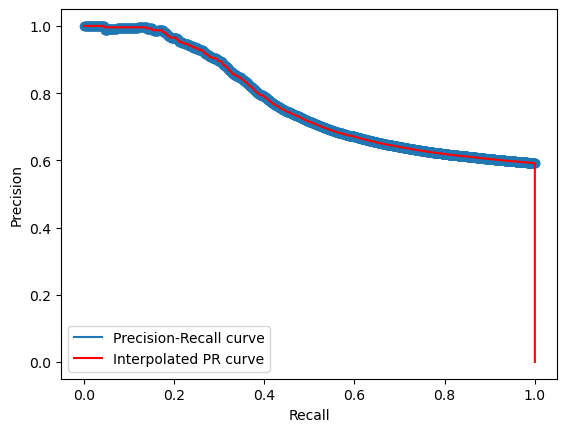

	Query 6


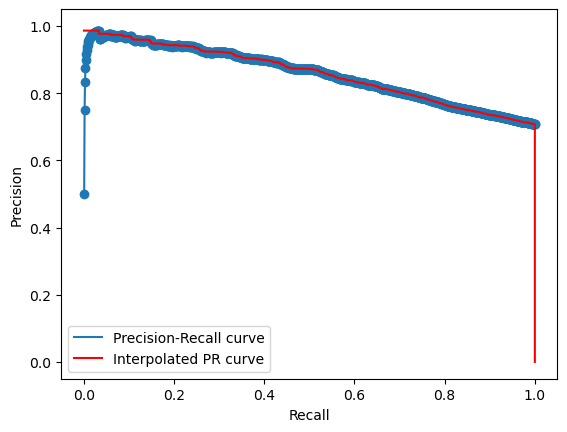

	Query 7


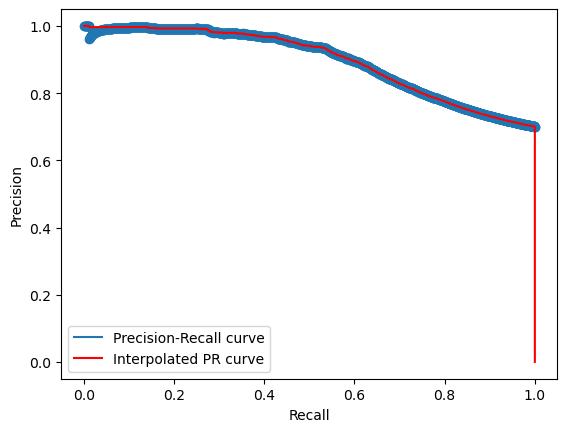

	Query 8


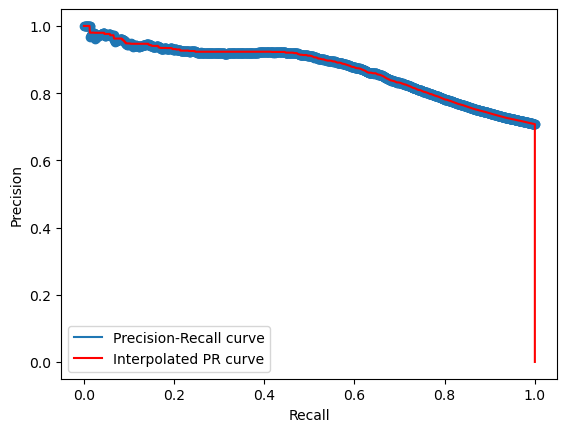

	Query 9


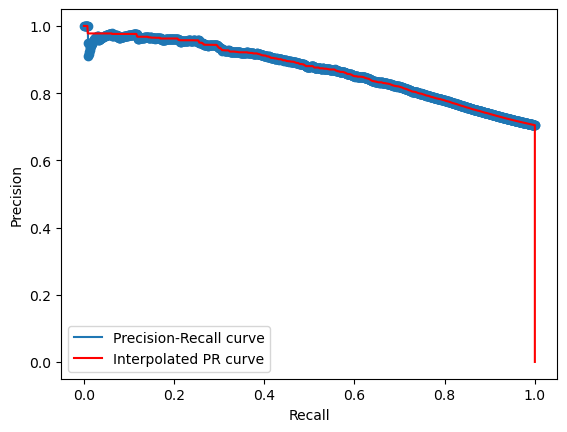

	Query 10


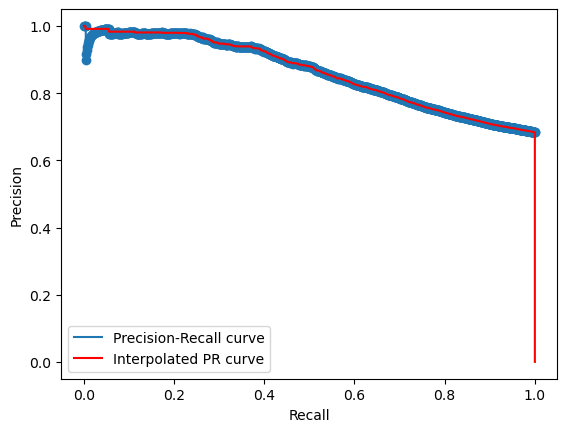

C:\Users\laura\AppData\Local\Temp\ipykernel_20120\3007299526.py:84: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if Prec_tot==[]:
C:\Users\laura\AppData\Local\Temp\ipykernel_20120\3007299526.py:95: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if Prec_tot==[]:



 Determine R-precision for each query
	Query 1
		Number of relevant documents: 913 --> P(913)=0.68
	Query 2
		Number of relevant documents: 875 --> P(875)=0.65
	Query 3
		Number of relevant documents: 882 --> P(882)=0.65
	Query 4
		Number of relevant documents: 918 --> P(918)=0.68
	Query 5
		Number of relevant documents: 881 --> P(881)=0.65
	Query 6
		Number of relevant documents: 1055 --> P(1055)=0.78
	Query 7
		Number of relevant documents: 1043 --> P(1043)=0.78
	Query 8
		Number of relevant documents: 1054 --> P(1054)=0.79
	Query 9
		Number of relevant documents: 1050 --> P(1050)=0.78
	Query 10
		Number of relevant documents: 1018 --> P(1018)=0.76

 Calculate the Mean Average Precision
	Query 1
		AP=1/913 {P(1) + P(3) + P(4) + P(5) + P(6) + P(7) + P(8) + P(9) + P(10) + P(11) + P(12) + P(13) + P(14) + P(15) + P(16) + P(17) + P(18) + P(19) + P(20) + P(21) + P(22) + P(23) + P(24) + P(25) + P(26) + P(27) + P(28) + P(29) + P(30) + P(31) + P(33) + P(34) + P(35) + P(36) + P(37) + P(38) + 

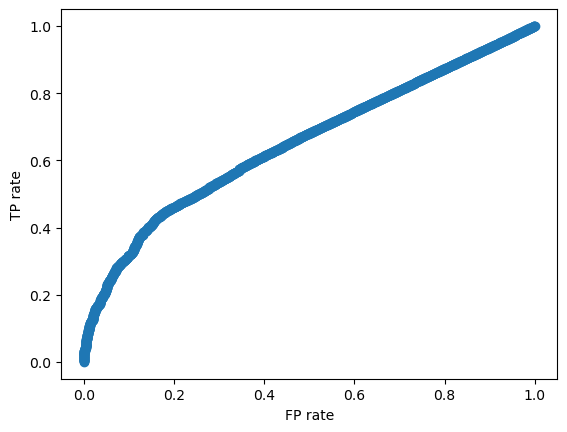

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

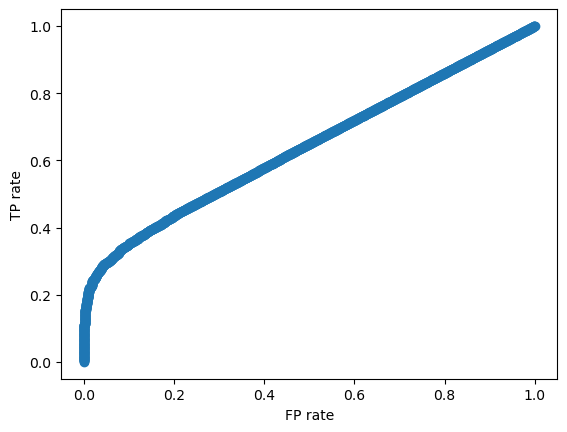

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

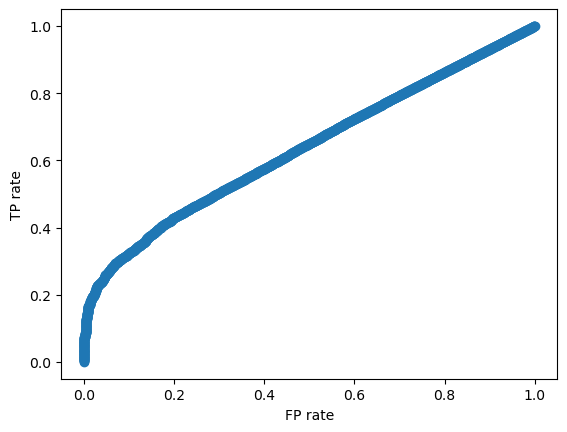

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

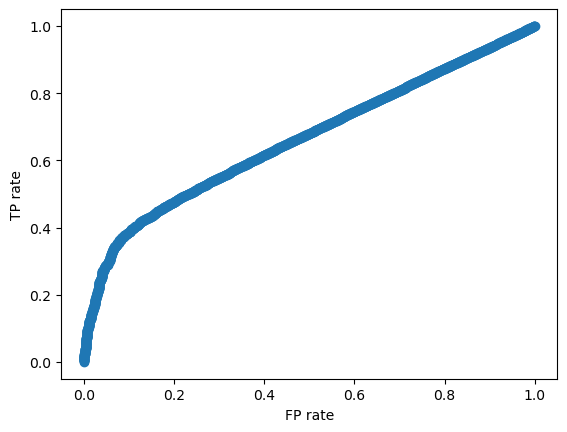

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

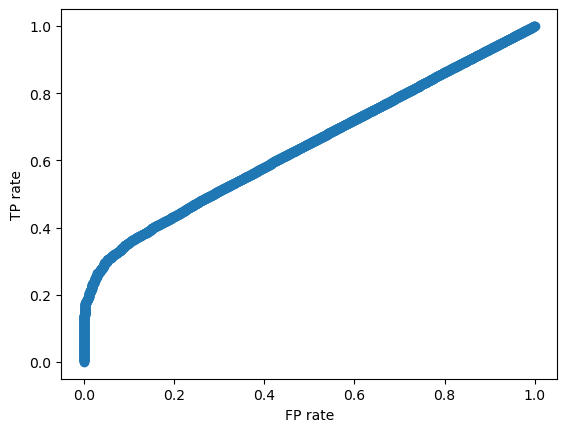

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

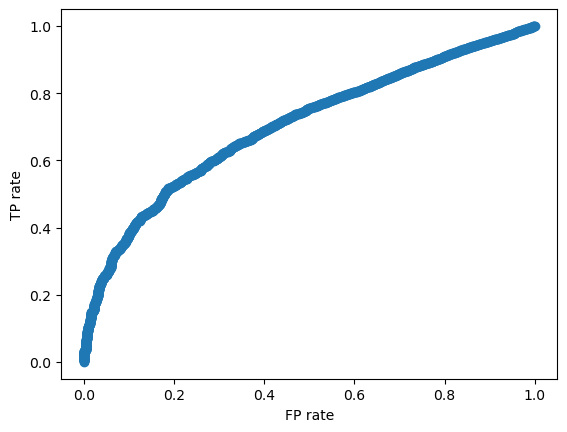

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

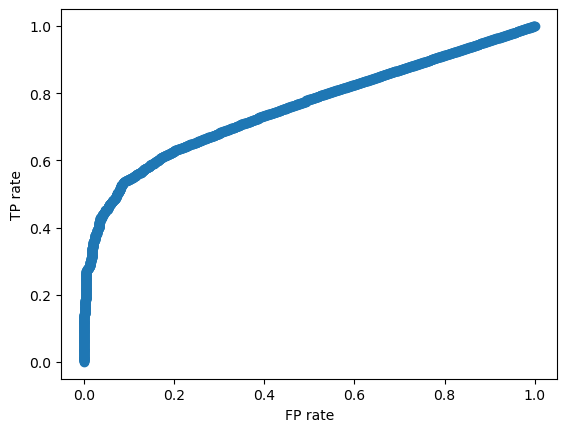

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

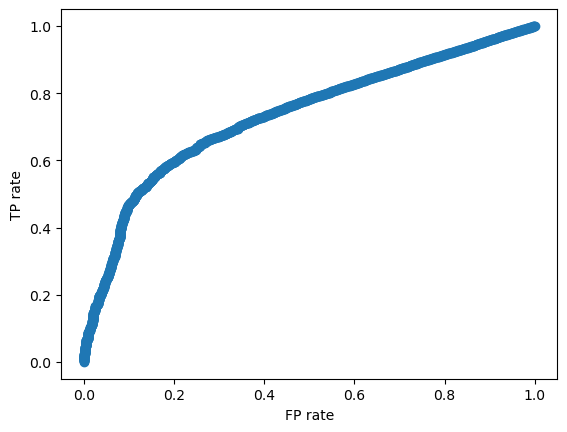

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

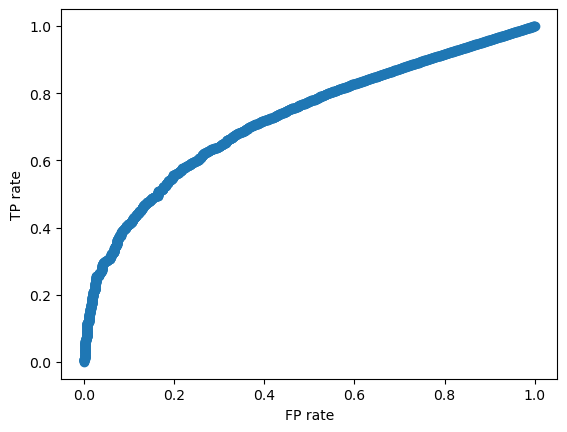

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

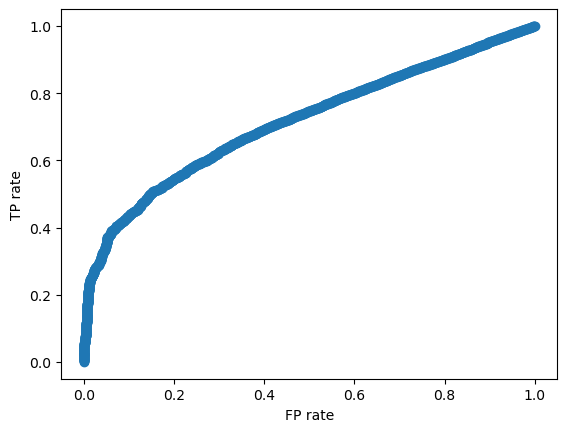

	AUC = 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 + 0.00 +

In [40]:
evaluate('all', q, r)

### 3.2- SECOND SOLUTION

Accuracy retrieving to the user with the maximun similarity

In [41]:
correct = 0
for i in range(1490):
    random_index = random.randint(0, len(train["Text"])-1) #get a random document from the dataset. 
    incoming_doc_vector = document_vectors[random_index]
    list_sim = []
    perfiles = []
    topics = []

    for j in range(len(users_vectors)-1):
        similarities = cosine_similarity(incoming_doc_vector, users_vectors[j]) #cosine distance between the document and the users.-
        #if similarities[0][0] > 0.0: #all values that are not 0 are saved 
        perfiles.append(j+1)
        topics.append(topics_interest[j])
        list_sim.append(similarities[0][0])

    #return the document, the users are going to receive that document and the main topic related to the document. 

    ranking = pd.DataFrame()
    ranking["Users"] = perfiles
    ranking['Topics'] = topics
    ranking["Score"] = list_sim
    ranking = ranking.sort_values('Score', ascending=False)
   
    max_index = ranking['Score'].idxmax() #df index of the maximun score value in the ranking
    max_row = ranking.loc[max_index]# row with the maximun score
    #print(train['Category'][random_index], '-- ', max_row['Topics'])
    #print(ranking)
    if train['Category'][random_index] in max_row['Topics']:
        correct +=1
acc = correct/1490
print('Accuracy: ', acc)

Accuracy:  0.9147651006711409


Accuracy using the threshold.

In [42]:
def accuracy(y_true, y_pred):
  # Calculate the number of correct predictions
  correct_predictions = 0

  for i in range(len(y_pred)):
      if y_true in y_pred[i]:
          correct_predictions +=1

      # Calculate the total number of predictions
      total_predictions = len(y_pred)

      # Calculate the accuracy
      accuracy = correct_predictions / total_predictions

  return accuracy

In [43]:
acc_results =[]
for key in users_interested_dict:
    category = train['Category'][key]
    predicted = users_interested_dict[key]
    acc = accuracy(y_true=category, y_pred=predicted)
    acc_results.append(acc)

print('Accuracy mean: ', np.mean(acc_results))

Accuracy mean:  0.7946588581669227


## 4- PERFORMANCE COMPARISION

Comparing with other groups, obtaining the 10 documents retreive to a user.

In [44]:
sort_10 = sim_df.sort_values('user10', ascending=False)
sort_10[:10]

,ArticleId,Text,user1,user2,user3,user4,user5,user6,user7,user8,user9,user10,Category
1242,1595,blair ready to call election tony blair seems ...,0.036467,0.006398,0.278639,0.014818,0.007094,0.207506,0.027433,0.014715,0.219897,0.202044,politics
1153,1853,surprise win for anti-bush film michael moore ...,0.005474,0.006723,0.065060,0.023355,0.216153,0.062519,0.007806,0.160834,0.049222,0.198848,entertainment
1156,1661,debate needed on donations cap a cap on donat...,0.003967,0.009744,0.268754,0.022568,0.010803,0.205996,0.008775,0.022409,0.190318,0.197677,politics
123,39,debate needed on donations cap a cap on donat...,0.003967,0.009744,0.268754,0.022568,0.010803,0.205996,0.008775,0.022409,0.190318,0.197677,politics
981,2069,online games play with politics after bubbling...,0.022729,0.130272,0.216118,0.140077,0.051582,0.251867,0.097917,0.128703,0.166679,0.189292,tech
287,2153,brown proud of economy record gordon brown h...,0.031327,0.005497,0.255323,0.012730,0.012188,0.189542,0.023566,0.016733,0.200038,0.189159,politics
907,1155,chancellor rallies labour voters gordon brown ...,0.042863,0.023929,0.254728,0.005542,0.010612,0.184039,0.042745,0.010848,0.207673,0.187624,politics
479,572,tories urge change at the top tory delegates...,0.006691,0.000000,0.238569,0.009516,0.018221,0.175422,0.004282,0.018626,0.171154,0.181578,politics
1432,1178,labour mps fears over squabbling if there is ...,0.004114,0.000000,0.254243,0.017551,0.000000,0.192188,0.002633,0.011786,0.180294,0.179777,politics
917,1034,labour s eu propaganda a taxpayer subsidise...,0.013547,0.011092,0.246895,0.000000,0.006149,0.174581,0.015769,0.004129,0.181749,0.178929,politics


In [45]:
print(list(sort_10[:10]['ArticleId']))

[1595, 1853, 1661, 39, 2069, 2153, 1155, 572, 1178, 1034]
